<h1> DSCI 100: Group 38 Project Proposal </h1>

<b> Dataset title: </b> <b> <a href="https://archive.ics.uci.edu/ml/datasets/User+Knowledge+Modeling"> User Knowledge Modeling Data Set </a> </b>

<b> Introduction: </b> The dataset we are using is the “User Knowledge Modelling Dataset” from the UCI Machine Learning Repository in which the population consists of 403 undergraduate students in the Department of Electrical Education of Gazi University in the 2009 semester. 
From the raw dataset, the target value is UNS and is classified through input values: STG, SCG, STR, LPR, and PEG. We decided to remove columns: STG, SCG, and STR, and only focus on columns: LPR and PEG through vertical filtering with the appropriate model data to report on. We chose to filter based on the quality of proficiency-based learning in the exam performances of users for goal objects, and for related objects with goal objects.


<b> Dataset terminology: </b>

<b> LPR </b> - the exam performance of the users for related objects with goal object 

<b> PEG </b> - the exam performance of the users for goal objects 

<b> UNS </b> - the knowledge level of the users about the subject of Electrical DC Machines

Our objective is to determine the category of UNS assigned to the user based on features LPR and PEG with k-NN classification. The target value is the knowledge level of students/ ‘users’ about the subject of Electrical DC Machines in which its features are LPR and PEG and its categories are:

 - Very low
 - Low
 - Middle
 - High

<br>

<i> Firstly, we loaded in the packages that were needed, set the seed so that everything is reproducible for the data analysis. </i>

In [1]:
library(tidyverse)
library(readxl)
library(tidymodels)

set.seed(9999)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘tidymodels’ was built under R version 4.0.2”
── Attaching packages ────────────────────────────────────── tidymodels 0.1.1 ──

✔ broom     0.7.0      ✔ recipes   0.1.13
✔ dials     0.0.9      ✔ rsample   0.0.7 
✔ infer     0.5.4      ✔ tune      0.1.1 
✔ modeldata 0.0.2      ✔ workflows 0.2.0 
✔ parsnip   0.1.3    

<br>

<i> We loaded the data into R by downloading the file, where we then read the training dataset. Then, we wrangled the data by selecting the needed variables LPR and PEG, and mutating UNS as a factor. There was no need to wrangle the data into tidy format since it was already provided as such. </i>

In [2]:
download.file("https://archive.ics.uci.edu/ml/machine-learning-databases/00257/Data_User_Modeling_Dataset_Hamdi%20Tolga%20KAHRAMAN.xls", "user_modeling_data.xls")
dataset_training <- read_excel('user_modeling_data.xls', sheet = 2) %>%
    select(LPR, PEG, UNS) %>%
    mutate(UNS = as_factor(UNS))
dataset_training

New names:
* `` -> ...7
* `` -> ...8



LPR,PEG,UNS
<dbl>,<dbl>,<fct>
0.00,0.00,very_low
0.24,0.90,High
0.25,0.33,Low
0.65,0.30,Middle
0.98,0.24,Low
0.10,0.66,Middle
0.29,0.56,Middle
0.40,0.01,very_low
0.72,0.25,Low


<br>


<i> By making a table, we can see the distribution of each status in the training data in regards to their counts and percentages. </i>

In [3]:
num_UNS <- dataset_training%>%
           group_by(UNS)%>%
           summarize(count = n(),
                    percentage = n() / nrow(dataset_training) *100)

num_UNS

`summarise()` ungrouping output (override with `.groups` argument)



UNS,count,percentage
<fct>,<int>,<dbl>
very_low,24,9.302326
High,63,24.418605
Low,83,32.170543
Middle,88,34.108527


<b> There is no missing data in the training data. </b>

<br>

<i> Through R, we also calculated the average LPR and PEG scores for the training data to be 0.43 and 0.46 respectively. </i>

In [4]:
LPRavg <- dataset_training %>%
    summarize(LPRavg = mean(LPR)) 

PEGavg <- dataset_training %>%
    summarize(PEGavg = mean(PEG)) 


bind_cols(LPRavg, PEGavg)

LPRavg,PEGavg
<dbl>,<dbl>
0.4327132,0.4585388


<br>

<i> Lastly, we explored the data using visualizations to represent and communicate numerics. We visualized the result through a scatter plot with the distribution of users’ exam performances, with PEG on the y-axis and LPR on the x-axis. We can then use colours to visualize and distinguish the knowledge level of each user. </i>

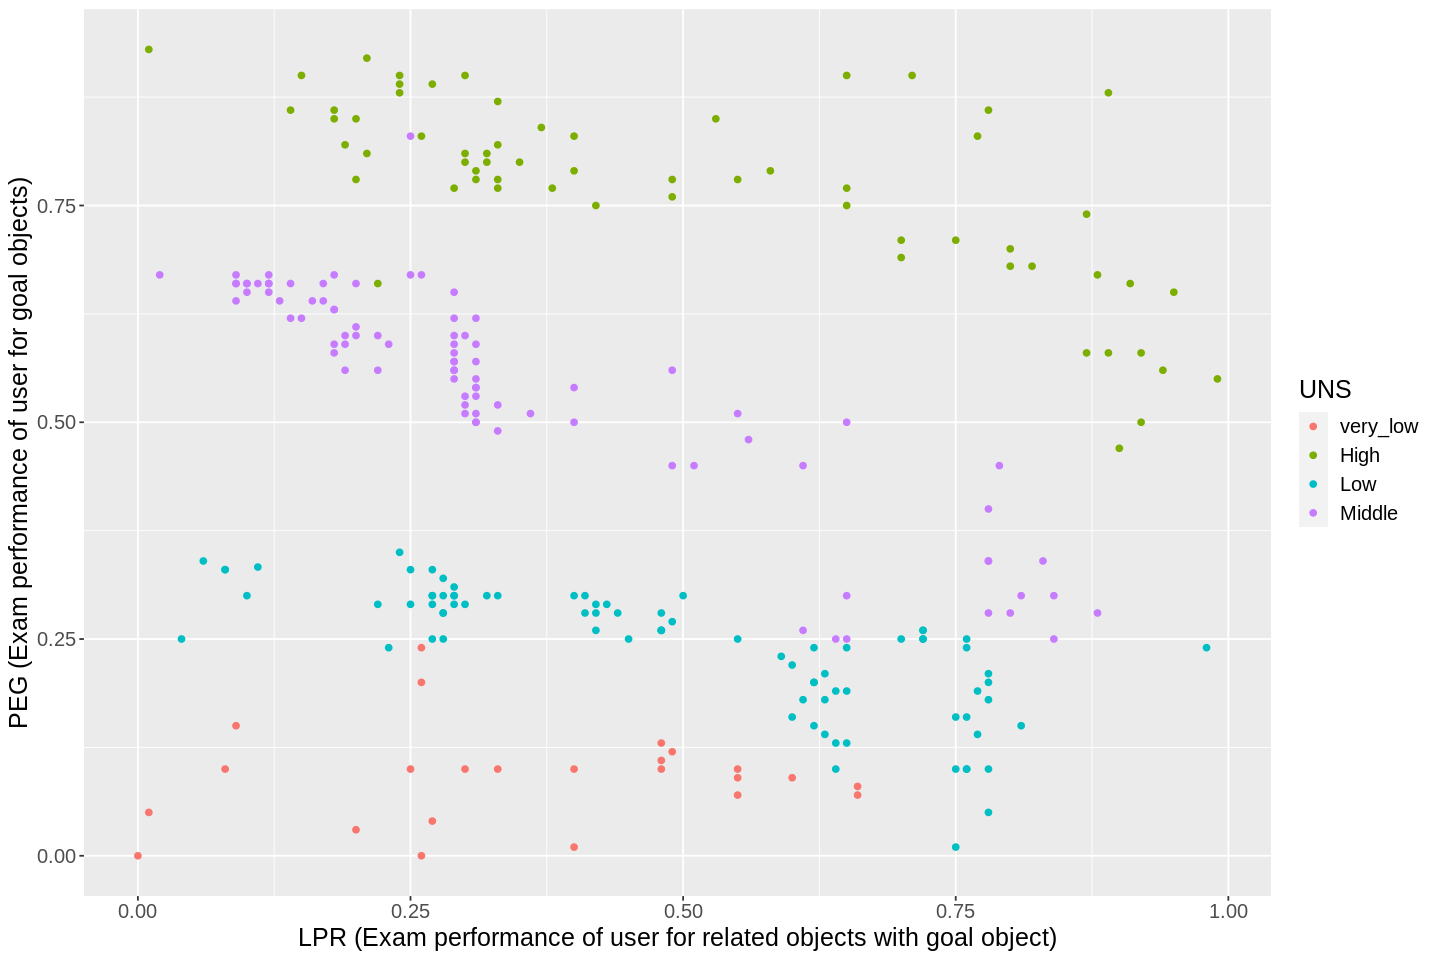

In [6]:
options(repr.plot.width = 12, repr.plot.height = 8)
plot <- dataset_training%>%
        ggplot(aes(x = LPR, y = PEG, color = UNS)) + 
        geom_point() + 
        labs(x = "LPR (Exam performance of user for related objects with goal object)", 
             y = "PEG (Exam performance of user for goal objects)", fill = "UNS") + theme(text = element_text(size = 15))
plot

<br>

<b> We see that in general, users with high scores in PEG tend to have a higher UNS regardless of LPR value. <b>

Overall, we expect there to be a positive correlation between high LPR and PEG values to higher categorical values of UNS such that the highest combined values should have a category of “high”. However, the initial data exploration suggested that only high PEG values contribute to a high UNS value, which leaves more up for interpretation. This would then suggest that a high level of exam performance correlates to a high knowledge level about Electrical DC Machines and propel further exploratory questions regarding if exam performance is an accurate indicator of knowledge regarding Electrical DC Machines. 